# **Working memory training**: multilevel modeling on whole-brain normalized recruitment/integration

**Last edited:** 12-05-2019

In [20]:
library(tidyverse)
library(nlme)
library(lattice)
library(RcppCNPy)
library(reticulate)

# Customizing theme for plotting
theme_training <- theme_bw() + theme(axis.text.y = element_text(size=25, colour='#262626ff'),
          axis.text.x = element_text(size=25, colour='#262626ff'),
          axis.title.y = element_text(size=25, colour='#262626ff'),
          axis.title.x  = element_text(size=25, colour='#262626ff'),
          plot.title = element_text(hjust=0.5, size=25),
          panel.grid.major = element_blank(), 
          panel.grid.minor = element_blank(),
          axis.line = element_line(colour="#262626ff"),
          panel.border = element_rect(colour = "#262626ff", fill=NA, size=1.8),
          panel.background = element_rect(fill="transparent",colour=NA),
          plot.background = element_rect(fill="transparent",colour=NA),
          legend.key = element_rect(fill= "transparent", colour="transparent"),
          strip.background =element_rect(fill="transparent", colour=NA),
          strip.text = element_text(size=25),
          axis.ticks = element_line(colour="#262626ff", size=1, 2),
          axis.ticks.length = unit(.15, "cm"),
          aspect.ratio = 1,
          )

## Step1: Loading data

In [21]:
setwd("~/Dropbox/Projects/LearningBrain/")

# Load parcellation
parcellation <- 'power'
filename <- paste('whole-brain', parcellation,'normalized_mean_allegiance_tidy.csv', sep = '_')

networks_allegiance <- read.csv(paste0('data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/', filename))
dualnback_exclude <- c('sub-13', 'sub-21', 'sub-23', 'sub-50') # higly motion subjects in one of four sessions
unique_networks <- unique(networks_allegiance$Network)
networks_allegiance$Session <- factor(networks_allegiance$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))
networks_allegiance$Group <- factor(networks_allegiance$Group, levels = c('Control', 'Experimental'))

networks_allegiance <- networks_allegiance %>% 
                       filter(!(Subject %in% dualnback_exclude))
head(networks_allegiance)

Subject,Session,Group,Network,AU,CER,CO,DA,DM,FP,MEM,SAL,SOM,SUB,UNC,VA,VIS
sub-01,Naive,Control,AU,1.1161623,0.8837633,1.0931980,0.9082316,0.9144164,0.9352113,0.9531491,0.9961401,1.0814334,1.0911097,0.9282743,1.0221006,0.9514352
sub-01,Naive,Control,CER,0.8837633,1.2210850,0.9187333,1.0258706,0.9905422,0.8590212,0.8865675,0.8247761,1.1157694,0.9741122,1.0603029,1.0017719,1.0970719
sub-01,Naive,Control,CO,1.0931980,0.9187333,1.1352952,0.9835624,0.9493048,1.0121652,1.0539031,1.0688459,1.0689615,1.1099719,0.9274441,0.9993909,0.9146693
sub-01,Naive,Control,DA,0.9082316,1.0258706,0.9835624,1.0814376,0.9890913,1.0764038,1.0763130,1.0186848,0.9789261,0.8905021,0.9524718,0.9818151,1.0442557
sub-01,Naive,Control,DM,0.9144164,0.9905422,0.9493048,0.9890913,1.0923545,0.9916978,1.0272787,1.0323955,0.9356249,0.9465844,1.0238902,0.9654402,0.9547721
sub-01,Naive,Control,FP,0.9352113,0.8590212,1.0121652,1.0764038,0.9916978,1.2738851,1.0218289,1.1299165,0.8969517,0.9515423,0.9963210,1.0568949,0.9925059


## Step 2: MLM modeling for all networks

In [22]:
mlm_stats <- data.frame()
mlm_params <- data.frame()

for (i in 1:length(unique_networks)){
    for (j in i:length(unique_networks)){
        
        network1 <- as.character(unique_networks[i])
        network2 <- as.character(unique_networks[j])
    
        net <- networks_allegiance %>% filter(Network == network1)
        variable <- net[[network2]]


        baseline <- lme(variable ~ 1, random = ~ 1 |Subject/Session, data = net, method = 'ML',  control=lmeControl(returnObject=TRUE))#control = list(opt = "optim"))
        session <- update(baseline, .~. + Session)
        group <- update(session, .~. + Group)
        session_group <- update(group, .~. + Session:Group)

        #print(paste(network1, network2))
        stats <- anova(baseline, session, group, session_group)
        params_session <- summary(session)
        params_interaction <- summary(session_group)
        
        vector_stats <- c(i, j, 
                          stats['L.Ratio'][2,], stats['L.Ratio'][3,], stats['L.Ratio'][4,], 
                          stats['p-value'][2,], stats['p-value'][3,], stats['p-value'][4,])
        
        vector_params <- c(i, j,
                           params_session$tTable[2,1], params_session$tTable[3,1], params_session$tTable[4,1], # betas
                           params_session$tTable[2,4], params_session$tTable[3,4], params_session$tTable[4,4], # ttests
                           params_session$tTable[2,5], params_session$tTable[3,5], params_session$tTable[4,5], # pvals
                           params_interaction$tTable[6,1], params_interaction$tTable[7,1], params_interaction$tTable[8,1], # betas
                           params_interaction$tTable[6,4], params_interaction$tTable[7,4], params_interaction$tTable[8,4], # ttests
                           params_interaction$tTable[6,5], params_interaction$tTable[7,5], params_interaction$tTable[8,5]) # pvals
                                    
        mlm_stats <- rbind(mlm_stats, vector_stats)
        mlm_params <- rbind(mlm_params, vector_params)
     }
}

colnames(mlm_stats) <- c('i', 'j', 
                         'chi_session', 'chi_group', 'chi_interaction', 
                         'pval_session', 'pval_group', 'pval_interaction')
colnames(mlm_params) <- c('i', 'j', 
                          'beta12_session', 'beta13_session', 'beta14_session', 
                          'ttest12_session', 'ttest13_session', 'ttest14_session',
                          'pval12_session', 'pval13_session', 'pval14_session',
                          'beta12_interaction', 'beta13_interaction', 'beta14_interaction', 
                          'ttest12_interaction', 'ttest13_interaction', 'ttest14_interaction',
                          'pval12_interaction', 'pval13_interaction', 'pval14_interaction')

#write.csv(mlm_stats, paste('data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/whole-brain', parcellation, 'normalized_mlm_stats.csv', sep = "_"))
#write.csv(mlm_params, paste('data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/whole-brain', parcellation,'normalized_mlm_params.csv', sep = "_"))

In [147]:
mlm_stats$pval_session_fdr <- p.adjust(mlm_stats$pval_session, method='fdr')
mlm_stats$pval_interaction_fdr <- p.adjust(mlm_stats$pval_interaction, method='fdr')

mlm_stats$net1 <- unique_networks[mlm_stats$i]
mlm_params$net1 <- unique_networks[mlm_params$i]
mlm_stats$net2 <- unique_networks[mlm_stats$j]
mlm_params$net2 <- unique_networks[mlm_params$j]


## Step 3: Planned contrasts and post-hocs:

In [144]:
library(emmeans)

network1 <- 'VA'
network2 <- 'SUB'
net = networks_allegiance %>% filter(Network == network1)
variable <- net[[network2]]


baseline <- lme(variable ~ 1, random = ~ 1 |Subject/Session, data = net, method = 'ML',  control=lmeControl(returnObject=TRUE))#control = list(opt = "optim"))
session <- update(baseline, .~. + Session)
group <- update(session, .~. + Group)
session_group <- update(group, .~. + Session:Group)
anova(baseline, session, group, session_group)
summary(session_group)



contrast(emmeans(session_group, ~ Session*Group),
         interaction = c("consec"), adjust = "bonferroni")

emmeans(session_group, pairwise ~ Session|Group, adjust = "bonferroni")

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
baseline,"lme.formula(fixed = variable ~ 1, data = net, random = ~1 | Subject/Session, method = ""ML"", control = lmeControl(returnObject = TRUE))",1,4,-434.68,-422.19,221.34,,NA,NA
session,"lme.formula(fixed = variable ~ Session, data = net, random = ~1 | Subject/Session, method = ""ML"", control = lmeControl(returnObject = TRUE))",2,7,-433.55,-411.68,223.78,1 vs 2,4.8677,0.181745
group,"lme.formula(fixed = variable ~ Session + Group, data = net, random = ~1 | Subject/Session, method = ""ML"", control = lmeControl(returnObject = TRUE))",3,8,-434.34,-409.35,225.17,2 vs 3,2.7896,0.094876
session_group,"lme.formula(fixed = variable ~ Session + Group + Session:Group, data = net, random = ~1 | Subject/Session, method = ""ML"", control = lmeControl(returnObject = TRUE))",4,11,-436.84,-402.48,229.42,3 vs 4,8.4987,0.036755


Linear mixed-effects model fit by maximum likelihood
 Data: net 
      AIC     BIC logLik
  -436.84 -402.48 229.42

Random effects:
 Formula: ~1 | Subject
        (Intercept)
StdDev:    0.029436

 Formula: ~1 | Session %in% Subject
        (Intercept) Residual
StdDev:     0.05259  0.02013

Fixed effects: variable ~ Session + Group + Session:Group 
                                   Value Std.Error  DF t-value p-value
(Intercept)                      1.05322  0.014208 120  74.128  0.0000
SessionEarly                    -0.00990  0.017807 120  -0.556  0.5793
SessionMiddle                   -0.00681  0.017807 120  -0.382  0.7028
SessionLate                      0.00034  0.017807 120   0.019  0.9849
GroupExperimental               -0.01732  0.020093  40  -0.862  0.3937
SessionEarly:GroupExperimental   0.03265  0.025183 120   1.296  0.1973
SessionMiddle:GroupExperimental -0.00911  0.025183 120  -0.362  0.7181
SessionLate:GroupExperimental   -0.03964  0.025183 120  -1.574  0.1181
 Correlatio

 Session_consec Group_consec           estimate     SE  df t.ratio p.value
 Early - Naive  Experimental - Control   0.0326 0.0252 120  1.296  0.5920 
 Middle - Early Experimental - Control  -0.0418 0.0252 120 -1.658  0.2997 
 Late - Middle  Experimental - Control  -0.0305 0.0252 120 -1.212  0.6836 

Degrees-of-freedom method: containment 
P value adjustment: bonferroni method for 3 tests 

$emmeans
Group = Control:
 Session emmean     SE df lower.CL upper.CL
 Naive    1.053 0.0142 41    1.025     1.08
 Early    1.043 0.0142 41    1.015     1.07
 Middle   1.046 0.0142 41    1.018     1.08
 Late     1.054 0.0142 41    1.025     1.08

Group = Experimental:
 Session emmean     SE df lower.CL upper.CL
 Naive    1.036 0.0142 40    1.007     1.06
 Early    1.059 0.0142 40    1.030     1.09
 Middle   1.020 0.0142 40    0.991     1.05
 Late     0.997 0.0142 40    0.968     1.03

Degrees-of-freedom method: containment 
Confidence level used: 0.95 

$contrasts
Group = Control:
 contrast        estimate     SE  df t.ratio p.value
 Naive - Early   0.009899 0.0178 120  0.556  1.0000 
 Naive - Middle  0.006810 0.0178 120  0.382  1.0000 
 Naive - Late   -0.000338 0.0178 120 -0.019  1.0000 
 Early - Middle -0.003089 0.0178 120 -0.174  1.0000 
 Early - Late   -0.010237 0.0178 120 -0.575  1.0000 
 Middle - Late  -0.007148 0.0178 120 -0.401  1.0000 

Group = Experimental:
 contrast        e

## Line plots

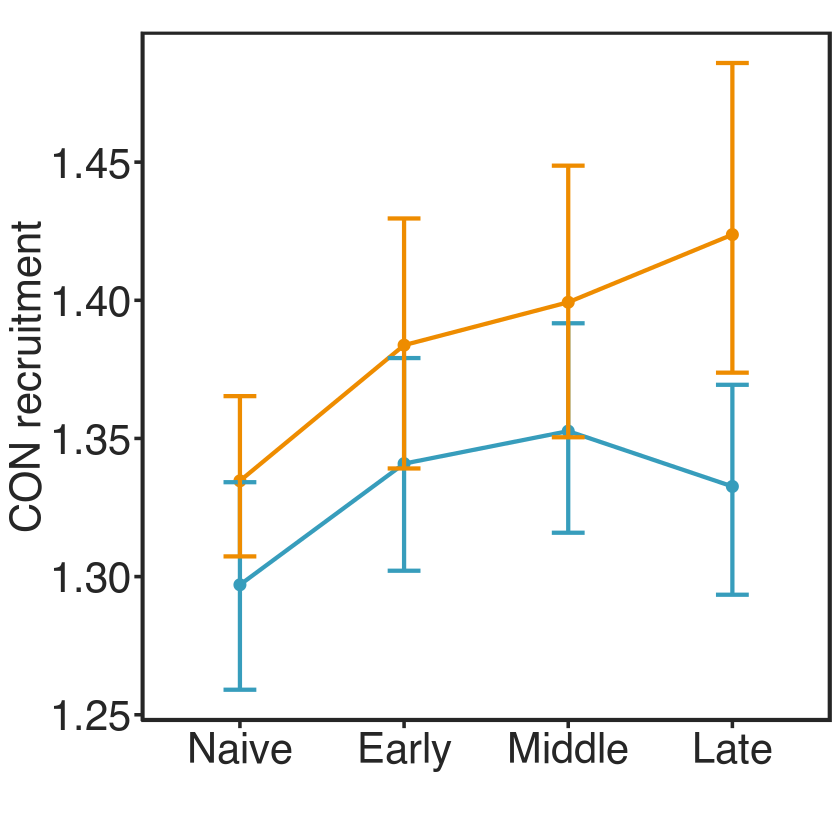

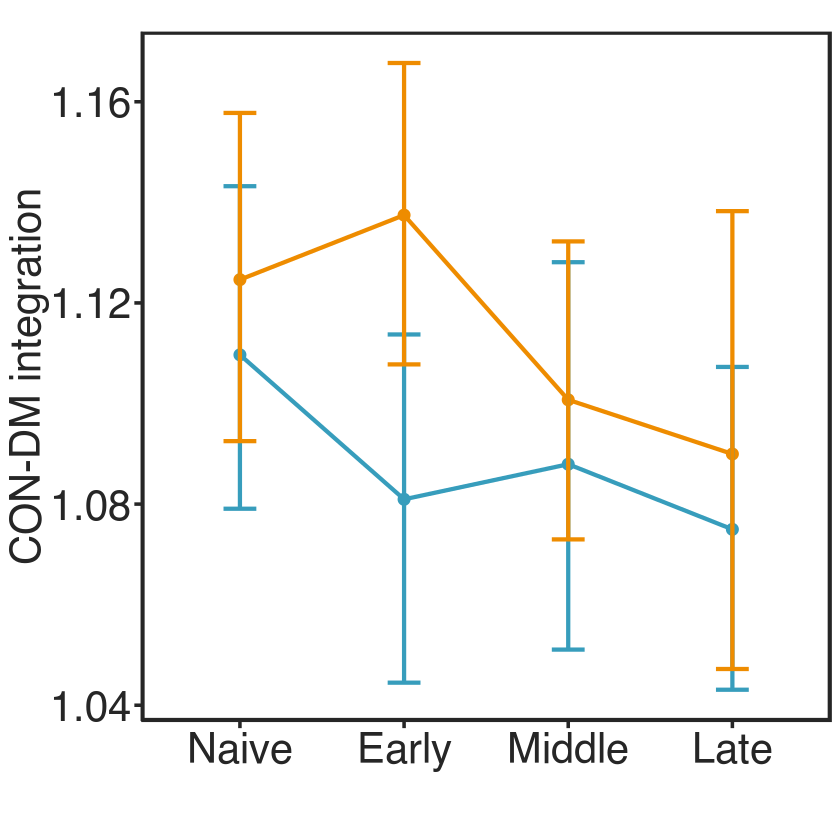

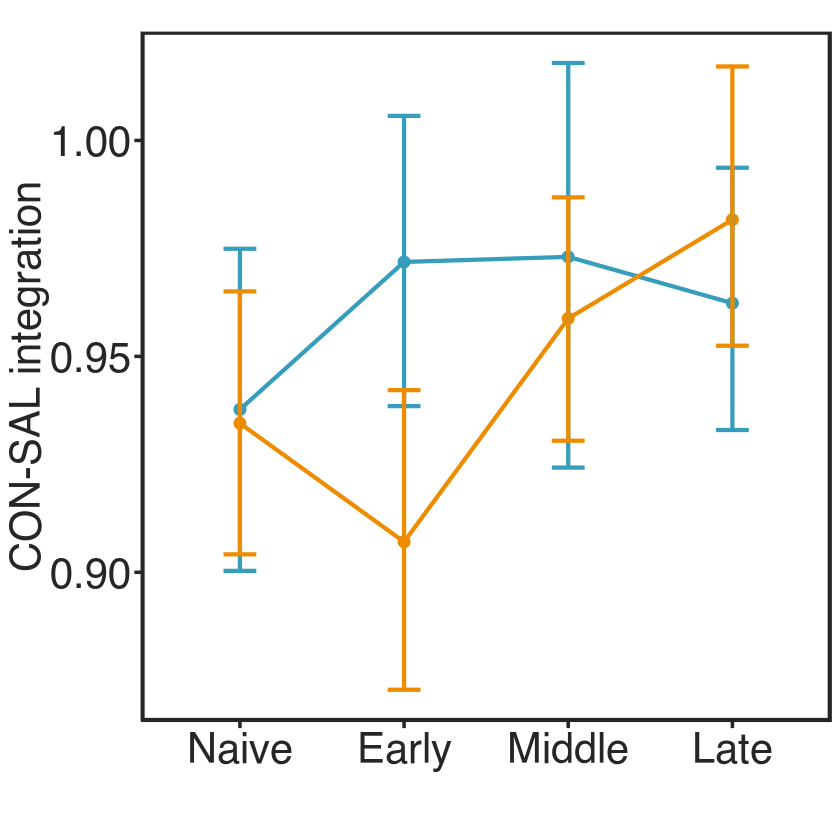

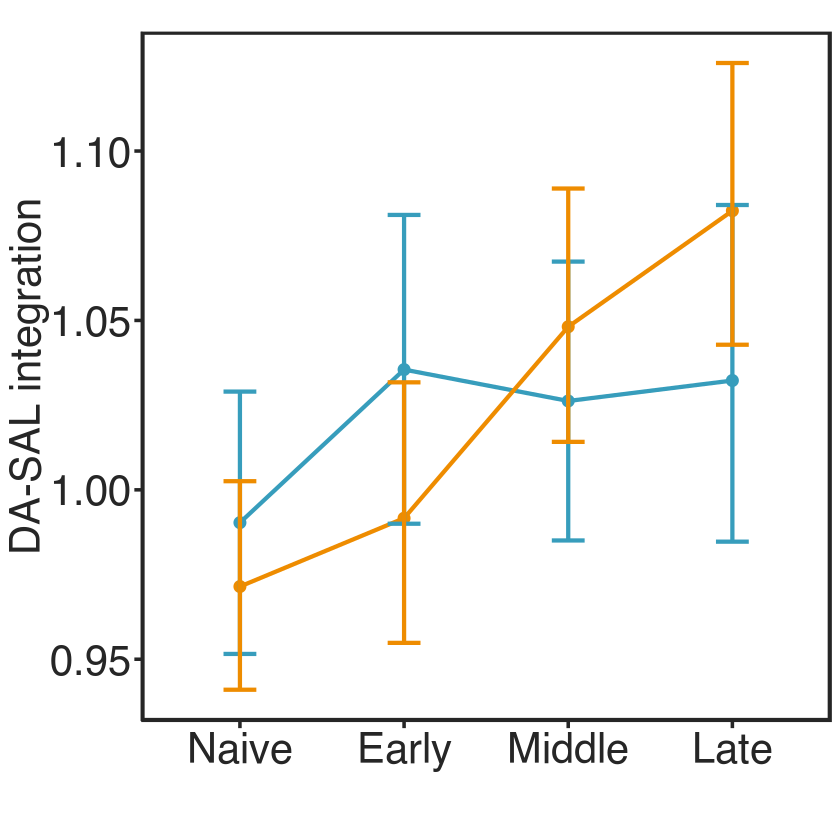

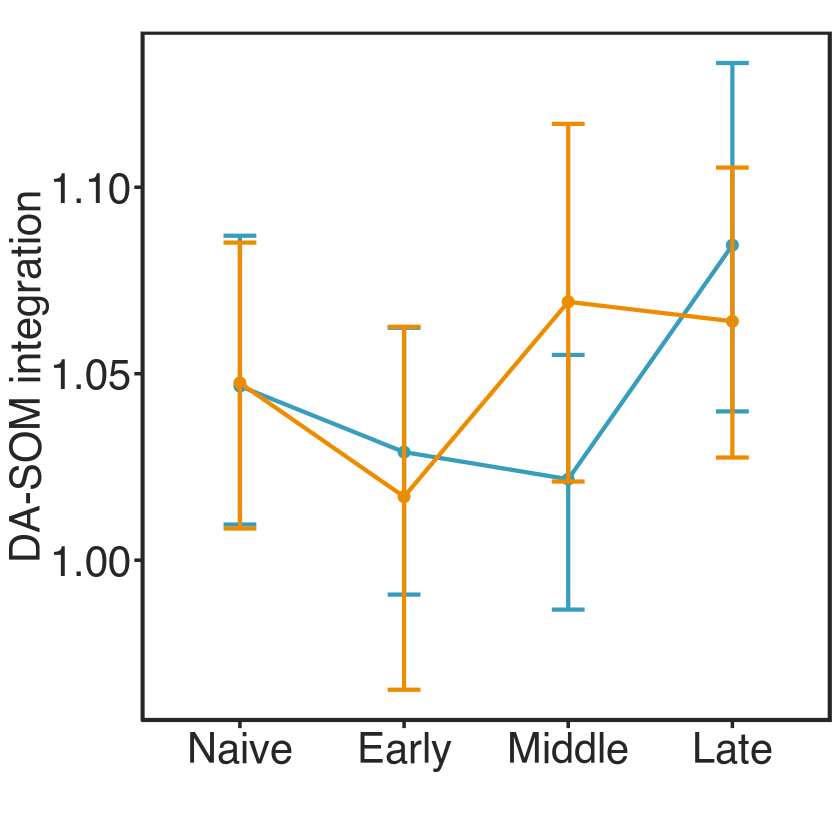

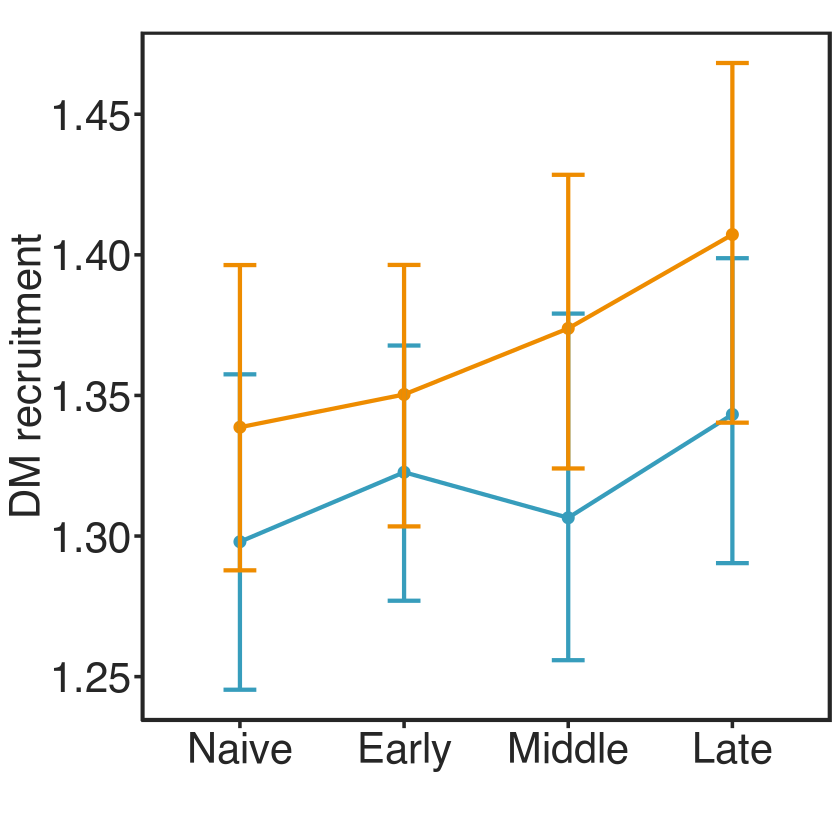

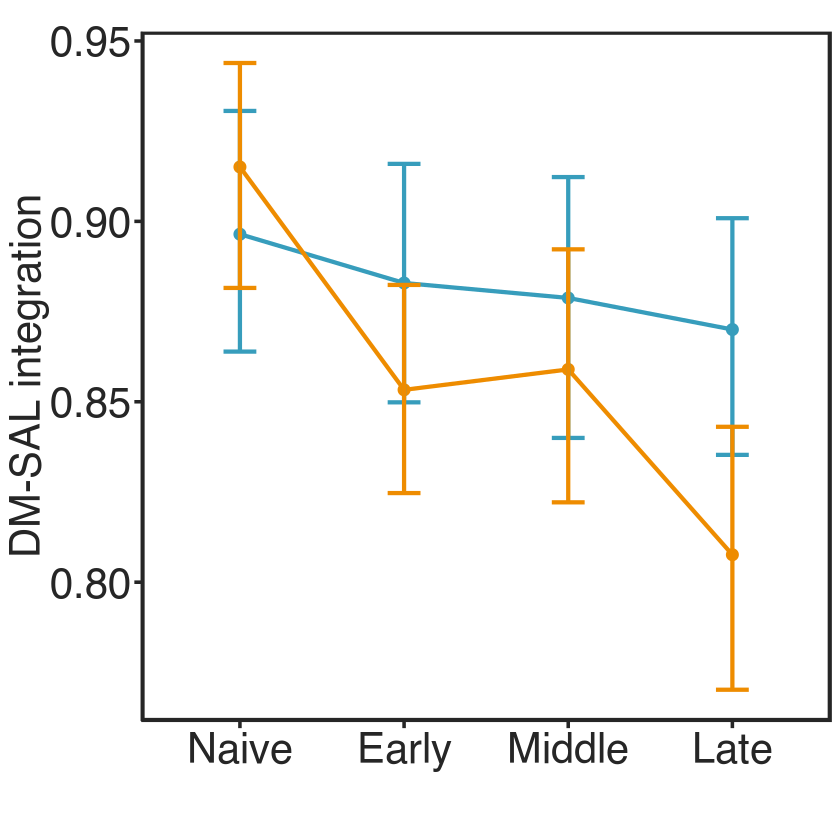

In [144]:
mlm_stats$pval_session_fdr <- p.adjust(mlm_stats$pval_session, method = "fdr")


for (i in 1:nrow(mlm_stats)){
   
    network1 = as.character(unique_networks[mlm_stats$i[i]])
    network2 = as.character(unique_networks[mlm_stats$j[i]])
    measure <- 'integration'
    label <- paste0(network1, '-', network2)
               
    if (mlm_stats$pval_session_fdr[i] < 0.05){    
        net <- networks_allegiance %>% filter(Network == network1)
        variable <- net[[network2]]
        
    if (network1 == network2){
        measure <- 'recruitment'
        label <- network1
        }
        
        p <- ggplot(net, aes(x = Session, y = variable, col = Group)) +
            stat_summary(fun.y = mean, geom = 'point', size = 3) +
            stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
            stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
            ylab(paste(label, measure)) +
            scale_colour_manual(values=c('#379dbc','#ee8c00')) +
            theme_training +
            theme(legend.position = "none") +
            xlab(' ') 
        print(p)
        
        #ggsave(paste0("figures/", paste0(label, '_', measure), ".pdf"), plot = p, width = 11, height = 5, dpi = 300)  
        
        }
}

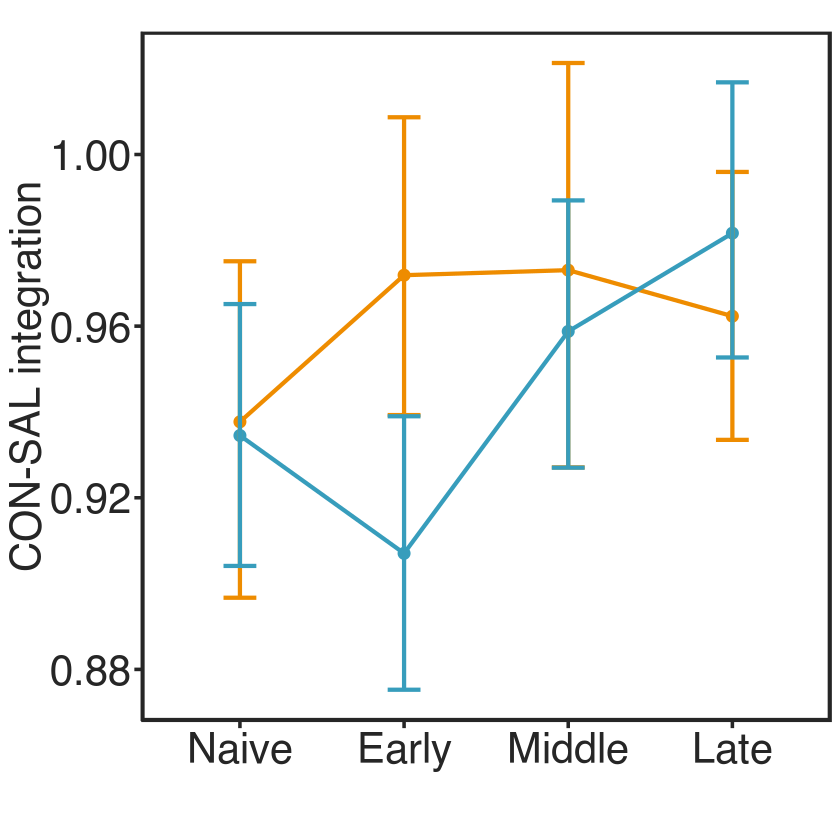

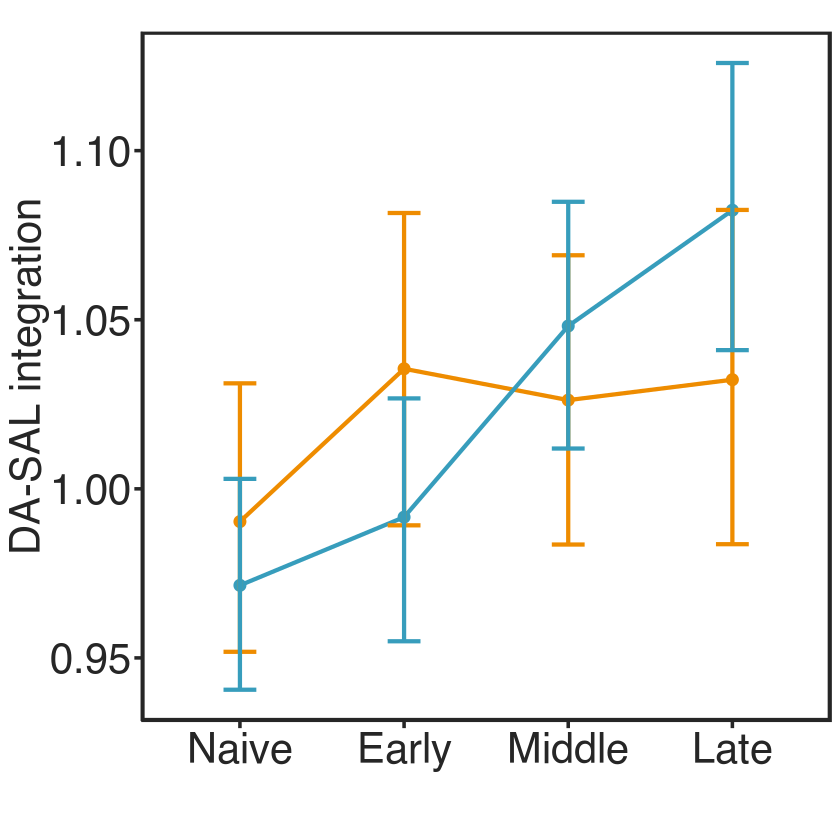

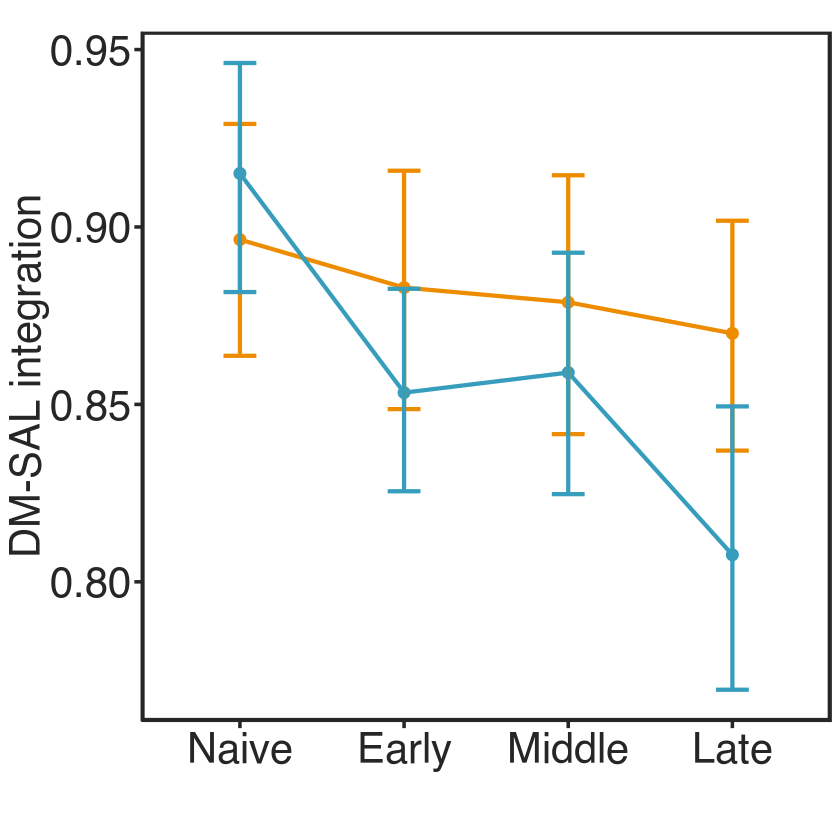

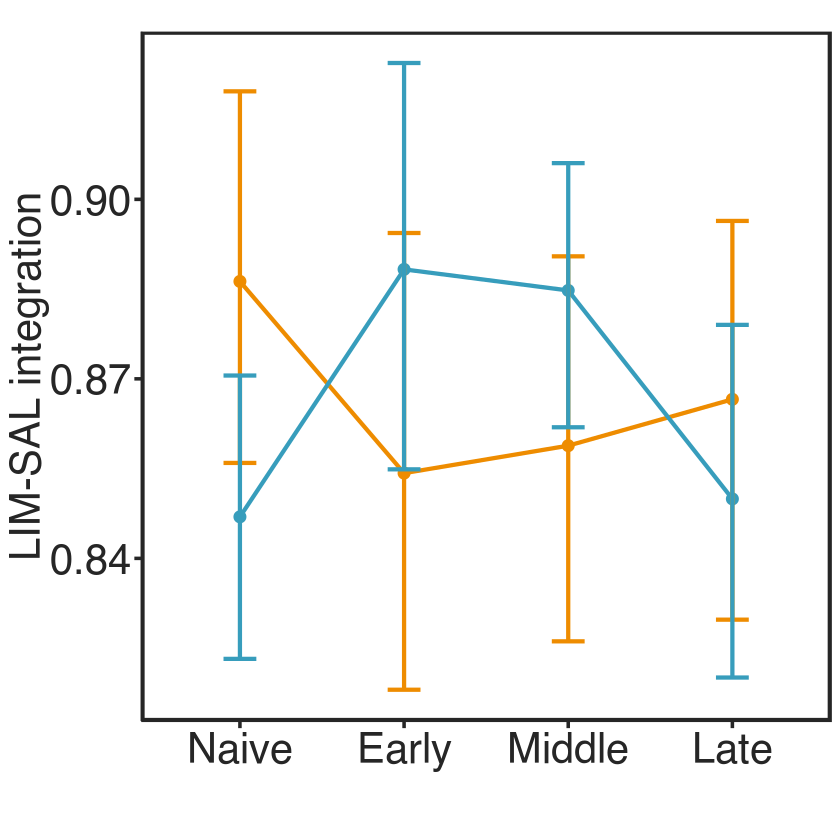

In [141]:
interactions <- data.frame()

for (i in 1:nrow(mlm_stats)){
   
    network1 = as.character(unique_networks[mlm_stats$i[i]])
    network2 = as.character(unique_networks[mlm_stats$j[i]])
    measure <- 'integration'
    label <- paste0(network1, '-', network2)
               
    if (mlm_stats$pval_interaction[i] < 0.05){    
        net <- networks_allegiance %>% filter(Network == network1)
        variable <- net[[network2]]
        
        inter <- mlm_params[i,]
        inter <- cbind(networks = label, inter)
        #inter$networks <- label
        interactions <- rbind(interactions, inter) 
        
        
    if (network1 == network2){
        measure <- 'recruitment'
        label <- network1
        }
        
        p <- ggplot(net, aes(x = Session, y = variable, col = Group)) +
            stat_summary(fun.y = mean, geom = 'point', size = 3) +
            stat_summary(fun.y = mean, geom = 'line', size = 1.2, aes(group = Group)) +
            stat_summary(fun.data = mean_cl_boot, geom = 'errorbar', width = 0.2, size = 1.2) +
            ylab(paste(label, measure)) +
            scale_colour_manual(values=c('#379dbc', '#ee8c00')) +
            theme_training +
            theme(legend.position = "none") +
            xlab(' ') 
        print(p)
        
        #ggsave(paste0("figures/", paste0(label, '_', measure, '_interaction.pdf')), plot = p, width = 11, height = 5, dpi = 300)  
        
        }
}

## Step 4: Group comparison in 'Naive' session

In [273]:
naive_pval <- data.frame()
naive_session <- networks_allegiance %>% filter(Session=='Naive') 

for (i in 1:length(unique_networks)){
    for (j in i:length(unique_networks)){
        
        network1 <- as.character(unique_networks[i])
        network2 <- as.character(unique_networks[j])
    
        net <- naive_session %>% filter(Network == network1)

        stat <- t.test(net[[network2]] ~ net$Group, paired = FALSE)
        x <- c(i, j, stat$p.value, stat$statistic)
        #print(x)
        
        naive_pval <- rbind(naive_pval, x)
        colnames(naive_pval) <- c('i', 'j', 'pval', 't')
        
        }
}

naive_pval$net1 <- unique_networks[naive_pval$i] 
naive_pval$net2 <- unique_networks[naive_pval$j]
naive_pval$pval_fdr <- p.adjust(naive_pval$pval, method = 'fdr')

naive_pval %>% filter (pval < 0.05)

i,j,pval,t,net1,net2,pval_fdr
1,1,0.0111777,-2.6631,AU,AU,0.45061
1,4,0.0205102,-2.4180,AU,DA,0.46661
1,11,0.0412432,2.1189,AU,UNC,0.54232
4,5,0.0328063,2.2111,DA,DM,0.54232
6,6,0.0148553,-2.5482,FP,FP,0.45061
6,12,0.0084522,-2.7704,FP,VA,0.45061
9,13,0.0417170,-2.1153,SOM,VIS,0.54232


### Relationship between modularity change and DM recruitment change


	Pearson's product-moment correlation

data:  net$DM and Q_clean$Q_norm
t = 9.37, df = 166, p-value <0.0000000000000002
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.47957 0.67918
sample estimates:
    cor 
0.58826 


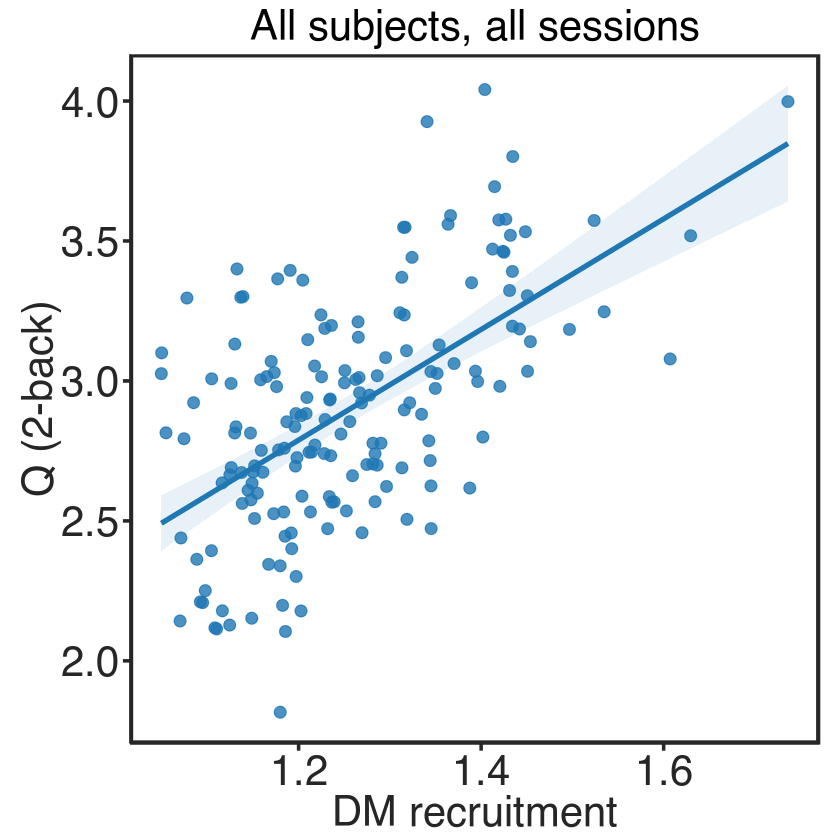

In [274]:
Q <- read.csv('data/neuroimaging/03-modularity/static/Q_normalized_power_tidy.csv') %>% 
     filter(Condition %in% c('1-back', '2-back'))

# Preparing data
Q$Session <- factor(Q$Session, levels = c('Naive', 'Early', 'Middle', 'Late'))
Q$Condition <- factor(Q$Condition, levels = c('1-back', '2-back'))
Q$Group <- factor(Q$Group, levels = c('Control', 'Experimental'))

# Subjects to exclude
dualnback_motion = c('sub-13', 'sub-21', 'sub-23', 'sub-50')

Q_clean <- Q %>% filter(!(Subject %in% dualnback_motion)) %>% filter(Condition %in% c('2-back'))

network1 <- 'DM'
net <- networks_allegiance %>% filter(Network == network1) #%>% filter(Group=='Experimental')
cor.test(net$DM, Q_clean$Q_norm)

results <- data.frame(cbind(net$DM, Q_clean$Q_norm))
names(results)[1:2] <- c('Recruitment', 'Modularity')

p <- results %>% ggplot(aes(Recruitment, Modularity)) +
    geom_point(size = 3, alpha = 0.8, col = '#1f77b4') +
    geom_smooth(method='lm', col = '#1f77b4', fill = '#1f77b4', size = 1.5, alpha = 0.1) +
    theme_training +
    xlab('DM recruitment') +
    ylab('Q (2-back)')  +
    ggtitle('All subjects, all sessions')
p

ggsave("figures/DM_Q_corr_2back_all.pdf", plot = p, width = 12, height = 6, dpi = 300)  


In [203]:
Q <- read_csv('/home/finc/Dropbox/Projects/LearningBrain/Q_beh_diff.csv')
network1 <- 'DM'
net = networks_allegiance %>% filter(Network == network1)
diff = net %>% filter(Session=='Late') %>% select(FP) - net %>% filter(Session=='Naive') %>% select(FP)
cor.test(diff$FP, Q$Q_norm_1back_change)


network1 <- 'DM'
#Q <- Q  %>% filter(Group=='Experimental')
net <- networks_allegiance %>% filter(Network == network1) #%>% filter(Group=='Experimental')
diff <- net %>% filter(Session=='Late') %>% 
        select(DM) - 
        net %>% 
        filter(Session=='Naive') %>% 
        select(DM)
cor.test(diff$DM, Q$Q_norm_1back_change)
cor.test(diff$DM, Q$Q_norm_2back_change)
cor.test(diff$DM, Q$Q_2back_1back_change)

Parsed with column specification:
cols(
  .default = col_double(),
  Subject = col_character(),
  Group = col_character()
)
See spec(...) for full column specifications.



	Pearson's product-moment correlation

data:  diff$DM and Q$Q_norm_1back_change
t = 2.84, df = 40, p-value = 0.007
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.12116 0.63482
sample estimates:
    cor 
0.40999 



	Pearson's product-moment correlation

data:  diff$DM and Q$Q_norm_2back_change
t = 1.97, df = 40, p-value = 0.056
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.0072126  0.5514608
sample estimates:
    cor 
0.29737 



	Pearson's product-moment correlation

data:  diff$DM and Q$Q_2back_1back_change
t = -0.955, df = 40, p-value = 0.35
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.43354  0.16200
sample estimates:
     cor 
-0.14928 


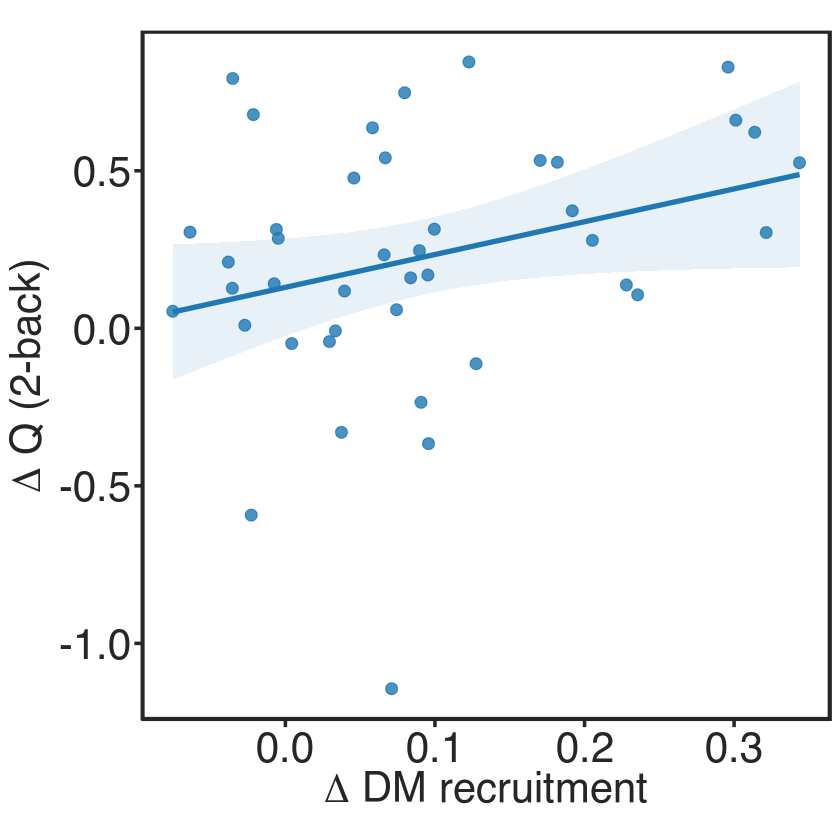

In [237]:
results <- data.frame(cbind(diff$DM, Q$Q_norm_2back_change))
colnames(results)[1:2] <- c("Recruitment", "Modularity") 

p <- results %>% ggplot(aes(Recruitment, Modularity)) +
    geom_point(size = 3, alpha = 0.8, col = '#1f77b4') +
    geom_smooth(method='lm', col = '#1f77b4', fill = '#1f77b4', size = 1.5, alpha = 0.1) +
    theme_training +
    xlab(expression(Delta*' DM recruitment')) +
    ylab(expression(Delta*' Q (2-back)'))    
p

ggsave("figures/DM_Q_corr_2back.pdf", plot = p, width = 12, height = 6, dpi = 300)  

### Relationship with behavioral change

In [23]:
#--- Behaviour
behaviour <- read.csv('./data/behavioral/WM_fmri_behaviour_mean_tidy.csv') %>% 
                       filter(!(Subject %in% dualnback_exclude))

# Behaviour 1-back
behaviour_1back <- behaviour %>% 
                   filter(Condition=='1-back') %>%
                   select(-Condition)

# Behaviour 2-back
behaviour_2back <- behaviour %>% 
                   filter(Condition=='2-back') %>% 
                   select(-Condition)

# Add 1-back/2-back labels to behaviour columns
colnames(behaviour_1back)[4:6] <- paste(colnames(behaviour_1back)[4:6], "1back", sep = "_")
colnames(behaviour_2back)[4:6] <- paste(colnames(behaviour_2back)[4:6], "2back", sep = "_")

# Calculate change from 1-back to 2-back
behaviour_2back_1back <- behaviour_2back[4:6] - behaviour_1back[4:6]
colnames(behaviour_2back_1back) <- paste(colnames(behaviour)[5:7], "delta", sep = "_")


behaviour_diff <- behaviour_1back %>% 
    left_join(behaviour_2back, by=c("Subject", "Session", "Group")) %>% 
    cbind(behaviour_2back_1back)

In [76]:
ses1 <- 'Naive'
ses2 <- 'Early'

behaviour_diff_1 <- behaviour_diff  %>% 
            filter(Group == 'Experimental') %>% 
            filter(Session == ses1)

behaviour_diff_2 <- behaviour_diff  %>% 
           filter(Group == 'Experimental') %>% 
            filter(Session == ses2)

networks_allegiance_1 <- networks_allegiance %>% 
            filter(Group == 'Experimental') %>% 
            filter(Session == ses1)

networks_allegiance_2 <- networks_allegiance %>% 
            filter(Group == 'Experimental') %>% 
            filter(Session == ses2)

beh1 <- behaviour_diff_1$Dprime_delta
beh2 <- behaviour_diff_2$Dprime_delta

beh_diff <- beh2 - beh1
#--------------------------------------------

results_df <- data.frame()

for (i in 1:length(unique_networks)){
    for (j in i:length(unique_networks)){
        
        network1 <- as.character(unique_networks[i])
        network2 <- as.character(unique_networks[j])
    
        net1 <- networks_allegiance_1  %>% 
            filter(Network == network1) 
        
        net2 <- networks_allegiance_2 %>% 
            filter(Network == network1)
        
        var1 <- net1[[network2]]
        var2 <- net2[[network2]]
        
        net_diff <- var2 - var1
        
        corr <- cor.test(beh_diff, net_diff, method = "pearson")
        
        results <- c(i, j, corr$estimate, corr$p.value)
        results_df <- rbind(results_df, results)
    }
}

colnames(results_df)[1:4] <- c('i', 'j', 'estimate', 'pval')
results_df$net1 <- unique_networks[results_df$i]
results_df$net2 <- unique_networks[results_df$j]
results_df$pval_fdr <- p.adjust(results_df$pval)
results_df %>% filter(pval < 0.05) %>% select(net1, net2, estimate, pval, pval_fdr)

net1,net2,estimate,pval,pval_fdr
AU,VA,0.4903851,0.0240127927,1.00000000
CER,DA,0.4585068,0.0365743723,1.00000000
CO,DA,0.4957494,0.0222872683,1.00000000
CO,SUB,-0.5159050,0.0166670006,1.00000000
DA,SOM,0.7105180,0.0003068366,0.02792213
DA,SUB,0.4700412,0.0315444066,1.00000000
DM,SAL,0.4558561,0.0378143370,1.00000000
FP,SOM,0.4491370,0.0411045974,1.00000000
